In [5]:
import numpy as np
import torch
import torch.autograd
from mpc import mpc
from mpc.mpc import GradMethods, QuadCost, LinDx
import matplotlib.pyplot as plt
from IPython import display

plt.rcParams["figure.figsize"] = (15,5)

In [6]:
from mpc.dynamics import AffineDynamics
dx = AffineDynamics(
    A = torch.tensor([[1.01, 0.01, 0],[0.01, 1.01, 0.01],[0, 0.01, 1.01]]),
    B = torch.eye(3)
)

In [7]:
torch.manual_seed(0)

n_batch, n_state, n_ctrl, T = 1, 3, 3, 10
n_sc = n_state + n_ctrl

goal_state = torch.Tensor([2,1,-1])
goal_weights = torch.ones(n_state)*2.287
goal_weights = torch.Tensor([2.4927, 2.4961, 2.4990])
px = -(goal_weights)*goal_state
p = torch.cat((px, torch.zeros(n_ctrl)))
p = p.unsqueeze(0).repeat(T, n_batch, 1)

# Randomly initialize a PSD quadratic cost and linear dynamics.
ctrl_weights = torch.Tensor([0.0241, 0.0299, 0.0251])
q = torch.cat([goal_weights, ctrl_weights])
Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
        T, n_batch, 1, 1
)

# The upper and lower control bounds.
u_lower = torch.tensor([-0.5,-0.5,-0.5], dtype=torch.float32)
u_lower = u_lower.repeat(T, n_batch, 1)
u_upper = torch.tensor([0.5,0.5,0.5], dtype=torch.float32)
u_upper = u_upper.repeat(T, n_batch, 1)

x_init = torch.randn(n_batch, n_state)
x_lqr, u_lqr, objs_lqr = mpc.MPC(
    n_state=n_state,
    n_ctrl=n_ctrl,
    T=T,
    u_lower=u_lower, 
    u_upper=u_upper,
    backprop=False,
    grad_method=mpc.GradMethods.AUTO_DIFF 
)(x_init, QuadCost(Q, p), dx)

[WARNING] pnqp warning: Did not converge


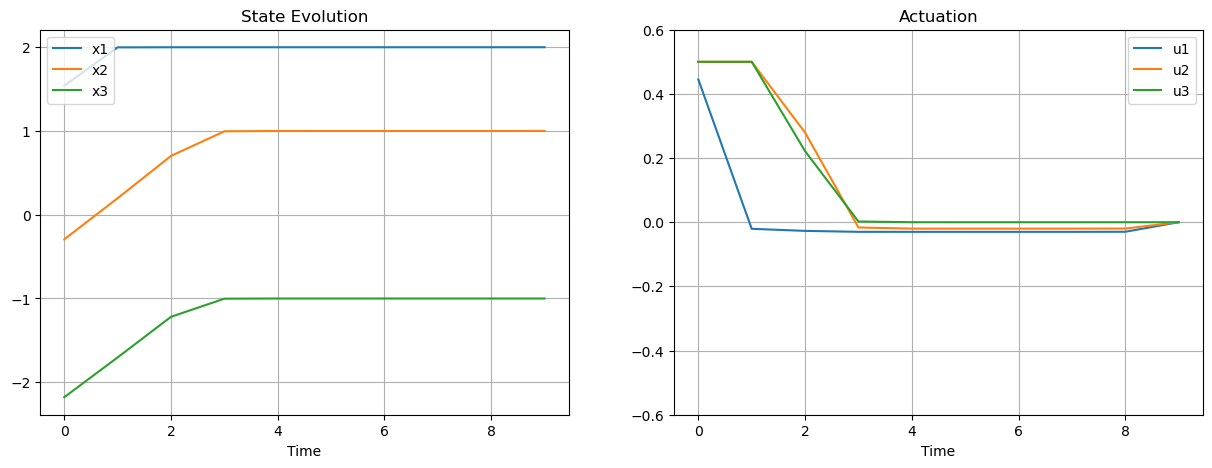

In [8]:
x1 = x_lqr[:,:,0][:,0]
x2 = x_lqr[:,:,1][:,0]
x3 = x_lqr[:,:,2][:,0]
u1 = u_lqr[:,:,0][:,0]
u2 = u_lqr[:,:,1][:,0]
u3 = u_lqr[:,:,2][:,0]

x = np.array([
    x1.detach().numpy(),
    x2.detach().numpy(),
    x3.detach().numpy()
])
u = np.array([
    u1.detach().numpy(),
    u2.detach().numpy(),
    u3.detach().numpy()
])

plt.subplot(1,2,1)
plt.plot(range(T), x.T, label=['x1','x2','x3'])
plt.title('State Evolution')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.grid('on')
plt.subplot(1,2,2)
plt.plot(range(T), u.T, label =['u1', 'u2', 'u3'])
plt.grid('on')
plt.legend(loc='upper right')
plt.title('Actuation')
plt.xlabel('Time')
plt.ylim(-0.6, 0.6)
plt.show()